# Introduction

This notebook is dedicated to calculating and predicting the credit approval from several features and using "Status" column as the target variable (or 'y'). Status has several data as category, that was:
- 0, C and X = Very Good (No Loan Problem)
- 1 = Good
- 2 - 3 = Not Bad
- 4 = Bad
- 5 = Very Bad

Tree-based models are particularly well-suited for this type of classification problem due to their ability to handle complex relationships between features and their robustness to different types of data distributions. The models were:
1. **AdaBoost Classifier**
2. **Decision Tree Classifier**
3. **XGBoost Classifier**

Using these machine learning models, the workflow will follow these steps:
- **Load Data:** Import the dataset and perform initial data inspection to understand its structure and contents.
- **Data Preprocessing:** Clean the data by handling missing values, encoding categorical variables, and normalizing numerical features where necessary.
- **Train-Test Split:** Divide the dataset into training and testing sets to evaluate model performance.
- **Smote Resample:** Resampling the train set data for handle the imbalances dataset.
- **Model Training:** Train the CatBoost and Random Forest models using the training data.
- **Model Evaluation:** Assess the performance of the trained models using various metrics.
- **Model Tuning:** Optimize model hyperparameters to improve accuracy and other performance metrics.
- **Features Importaces Permutation:** Conduct a features that was important and less important.
- **Final Evaluation:** Conduct a final evaluation of the tuned models on the test data.

For evaluating the performance of the models, the following metrics will be used:
- **Accuracy:** The proportion of correctly classified instances out of the total instances.
- **F1 Score:** The harmonic mean of precision and recall, which provides a balance between the two.
- **Recall Score:** The ability of the model to correctly identify all relevant instances (i.e., correctly predicting cancellations).

In [1]:
#!nvcc -V && which nvcc

In [2]:
#!python --version
#!nvidia-smi

# Importing Libraries

In [52]:
# importing libraries fundamentals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import warnings
import datetime
from matplotlib import pyplot

# Library for Null Values Imputing
import missingno as msno

# Library for Encoding and Imputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import  OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# for multiclass data dealt with it
from imblearn.over_sampling import SMOTE

# Library for Machine Learning Frameworks
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import joblib

# importing cudas

# Loading the Dataset

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-approval-prediction/credit_record.csv
/kaggle/input/credit-card-approval-prediction/application_record.csv


In [5]:
# load cudas extension

# %load_ext cudf.pandas

df = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv')
df2 = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv')

## Dataset Information

In [6]:
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [7]:
df2.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [8]:
print(df.shape)
print(df2.shape)

(438557, 18)
(1048575, 3)


In [9]:
print(f"Comparison rows of df 1 and df 2 id {438557/1048575 * 100} %")

Comparison rows of df 1 and df 2 id 41.824094604582406 %


In [10]:
df.describe()
# description of dataset

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [11]:
df.describe(include='object').T

,count,unique,top,freq
CODE_GENDER,438557,2,F,294440
FLAG_OWN_CAR,438557,2,N,275459
FLAG_OWN_REALTY,438557,2,Y,304074
NAME_INCOME_TYPE,438557,5,Working,226104
NAME_EDUCATION_TYPE,438557,5,Secondary / secondary special,301821
NAME_FAMILY_STATUS,438557,5,Married,299828
NAME_HOUSING_TYPE,438557,6,House / apartment,393831
OCCUPATION_TYPE,304354,18,Laborers,78240


In [12]:
df.info(), df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

(None, None)

In [13]:
df.shape

(438557, 18)

## Find the Categorical and Numerical dtype

### dataframe 1

In [14]:
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')


In [15]:
for col in object_columns:
    d_type = df[col].dtype

    counts =df[col].value_counts()
    print(f"Counts for {col}:")
    print(counts)
    print("============================================================")

Counts for CODE_GENDER:
CODE_GENDER
F    294440
M    144117
Name: count, dtype: int64
Counts for FLAG_OWN_CAR:
FLAG_OWN_CAR
N    275459
Y    163098
Name: count, dtype: int64
Counts for FLAG_OWN_REALTY:
FLAG_OWN_REALTY
Y    304074
N    134483
Name: count, dtype: int64
Counts for NAME_INCOME_TYPE:
NAME_INCOME_TYPE
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64
Counts for NAME_EDUCATION_TYPE:
NAME_EDUCATION_TYPE
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64
Counts for NAME_FAMILY_STATUS:
NAME_FAMILY_STATUS
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: in

In [16]:
num_columns = df.select_dtypes(include=['float', 'int64']).columns
print(num_columns)

Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS'],
      dtype='object')


### dataframe 2

In [17]:
object_columns2 = df2.select_dtypes(include=['object']).columns
print(object_columns2)

Index(['STATUS'], dtype='object')


In [18]:
for col in object_columns2:
    d_type = df2[col].dtype

    counts =df2[col].value_counts()
    print(f"Counts for {col}:")
    print(counts)
    print("============================================================")

Counts for STATUS:
STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64


In [19]:
num_columns2 = df2.select_dtypes(include=['float', 'int64']).columns
print(num_columns2)

Index(['ID', 'MONTHS_BALANCE'], dtype='object')


## Dealt with Null Values



In [20]:
df.isnull().sum(),

(ID                          0
 CODE_GENDER                 0
 FLAG_OWN_CAR                0
 FLAG_OWN_REALTY             0
 CNT_CHILDREN                0
 AMT_INCOME_TOTAL            0
 NAME_INCOME_TYPE            0
 NAME_EDUCATION_TYPE         0
 NAME_FAMILY_STATUS          0
 NAME_HOUSING_TYPE           0
 DAYS_BIRTH                  0
 DAYS_EMPLOYED               0
 FLAG_MOBIL                  0
 FLAG_WORK_PHONE             0
 FLAG_PHONE                  0
 FLAG_EMAIL                  0
 OCCUPATION_TYPE        134203
 CNT_FAM_MEMBERS             0
 dtype: int64,)

In [21]:
df2.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [22]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   OCCUPATION_TYPE  304354 non-null  object
dtypes: object(1)
memory usage: 3.3+ MB


In [23]:
def fill_categorical(df):
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

df = fill_categorical(df)

/tmp/ipykernel_34/635066549.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [24]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Empty DataFrame


theres no null value again :)

## Dealt with Duplicated Value

In [25]:
df['ID'].duplicated().sum()

47

In [26]:
df = df.drop_duplicates(subset='ID',keep='first')

In [27]:
df['ID'].duplicated().sum()

0

# Feature Engineering 

## Classifying Status for Good Interpretation

from original dataset, the int in "STATUS", stands for:
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month 
- X: No loan for the month

Then i classification again dataset for good interpretation. Credit Classes that i classified:

- 0, C and X = Very Good (No Loan Problem)
- 1 = Good
- 2 - 3 = Not Bad
- 4 = Bad
- 5 = Very Bad

In [28]:
df2['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [29]:
def classify_client(status):
    if status in ['C', 'X', '0']:
        return 'Very Good'
    elif status in ['1']:
        return 'Good'
    elif status in ['2', '3']: 
        return 'Not Bad'
    elif status in ['4']:
        return 'Bad'
    elif status in ['5']:
        return 'Very Bad'
    else:
        return 'Unknown'

df2['STATUS'] = df2['STATUS'].apply(classify_client)
print(df2['STATUS'].value_counts())

STATUS
Very Good    1034381
Good           11090
Very Bad        1693
Not Bad         1188
Bad              223
Name: count, dtype: int64


In [30]:
# Retrieve Data to 'int' again and Rank the Classes into'int'

def retrieve_data(status):
    if status in ['Very Good']:
        return 1
    elif status in ['Good']:
        return 2
    elif status in ['Not Bad']:  # corrected this line
        return 3
    elif status in ['Bad']:
        return 4
    elif status in ['Very Bad']: 
        return 5
    else:
        return 0

df2['STATUS'] = df2['STATUS'].apply(retrieve_data)
print(df2['STATUS'].value_counts())

STATUS
1    1034381
2      11090
5       1693
3       1188
4        223
Name: count, dtype: int64


In [31]:
# Group by ID and create separate DataFrames for STATUS and MONTHS_BALANCE

credit_status = df2.groupby('ID')['STATUS'].agg("max").reset_index()
months_balance = df2.groupby('ID')['MONTHS_BALANCE'].agg("max").reset_index()

# Merging the dataframes

df = pd.merge(df, credit_status, how='inner', on='ID')
df = pd.merge(df, months_balance, how='inner', on='ID')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [33]:
df = df.sort_values('AMT_INCOME_TOTAL')
df = df.reset_index(drop=True)
df.ID=df.index
df.columns = ('User_id',
              'Gender',
              'Car',
              'Realty',
              'children_count',
              'income_amount',
              'income_type',
              'education_type',
              'Family_status',
              'Housing_type',
              'Days_birth',
              'Days_employed',
              'Mobile',
              'Work_phone',
              'Phone',
              'Email',
              'Occupation_type',
              'Count_family_members',
              'Status',
              'Month_Balance'
              )

## Drop some useless features

In [34]:
df = df.drop(["Days_birth", "Mobile", "Phone", "Work_phone", "Email", 
               "Count_family_members", "children_count", "Gender", 'User_id'], axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Car              36457 non-null  object 
 1   Realty           36457 non-null  object 
 2   income_amount    36457 non-null  float64
 3   income_type      36457 non-null  object 
 4   education_type   36457 non-null  object 
 5   Family_status    36457 non-null  object 
 6   Housing_type     36457 non-null  object 
 7   Days_employed    36457 non-null  int64  
 8   Occupation_type  36457 non-null  object 
 9   Status           36457 non-null  int64  
 10  Month_Balance    36457 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 3.1+ MB


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Car              36457 non-null  object 
 1   Realty           36457 non-null  object 
 2   income_amount    36457 non-null  float64
 3   income_type      36457 non-null  object 
 4   education_type   36457 non-null  object 
 5   Family_status    36457 non-null  object 
 6   Housing_type     36457 non-null  object 
 7   Days_employed    36457 non-null  int64  
 8   Occupation_type  36457 non-null  object 
 9   Status           36457 non-null  int64  
 10  Month_Balance    36457 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 3.1+ MB


# Split data, SMOTE and Encoding

In [36]:
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['Car', 'Realty', 'income_type', 'education_type', 'Family_status',
       'Housing_type', 'Occupation_type'],
      dtype='object')


In [37]:
X = df.drop('Status', axis=1)
y = df['Status']

In [38]:
def one_hot_encode_categorical(X, categorical_columns):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_array_X = encoder.fit_transform(X[categorical_columns])
    encoded_df_X = pd.DataFrame(encoded_array_X, columns=encoder.get_feature_names_out(categorical_columns))
    X = X.drop(columns=categorical_columns)
    X = pd.concat([X, encoded_df_X], axis=1)
    return X

X_encoded = one_hot_encode_categorical(X, categorical_columns)

In [39]:
X_train , X_test , y_train , y_test = train_test_split(X_encoded, y, test_size=0.2 , random_state=42)

# Class Weigting (Multiclass Imbalanced)

Distribution of Percentage: Status
1    88.229970
2    10.080369
3     1.069753
5     0.493732
4     0.126176
Name: proportion, dtype: float64


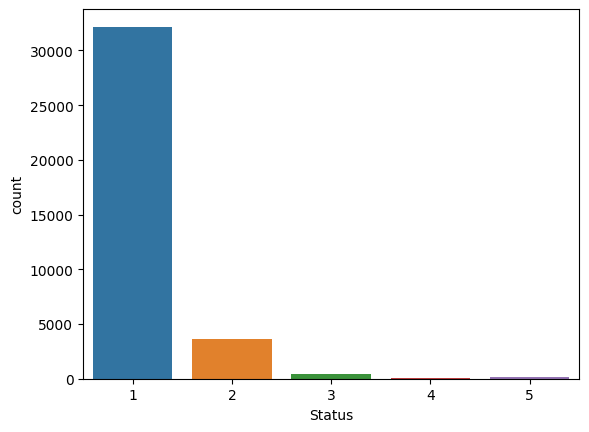

In [40]:
sns.countplot(x='Status', data=df)
print(f"Distribution of Percentage: {df['Status'].value_counts(normalize=True) * 100}")

In [41]:
# balancing the weights for machine learning

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Resampled X_train shape:", X_train.shape)
print("Resampled y_train shape:", y_train.shape)

Resampled X_train shape: (128630, 39)
Resampled y_train shape: (128630,)


# Models of Machine Learning

## Adaboost Classifier Model

In [42]:
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)

print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           1       0.89      0.53      0.66      6440
           2       0.11      0.20      0.14       732
           3       0.03      0.24      0.05        74
           4       0.00      0.18      0.01        11
           5       0.01      0.17      0.01        35

    accuracy                           0.49      7292
   macro avg       0.21      0.26      0.17      7292
weighted avg       0.80      0.49      0.60      7292



In [43]:
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

grid_search_ada = GridSearchCV(
    ada_model,
    param_grid=ada_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search_ada.fit(X_train, y_train)

# Access the best parameters and best estimator
best_params_ada = grid_search_ada.best_params_
best_score_ada = grid_search_ada.best_score_

# Print the results
print(f"Best Parameters: {best_params_ada}")
print(f"Best Cross-Validation Score: {best_score_ada:.4f}")

Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}
Best Cross-Validation Score: 0.4914


In [44]:
best_model_ada = grid_search_ada.best_estimator_
best_model_ada.fit(X_train, y_train)
best_pred_ada = best_model_ada.predict(X_test)

print(classification_report(y_test, best_pred_ada))

              precision    recall  f1-score   support

           1       0.89      0.54      0.67      6440
           2       0.12      0.19      0.15       732
           3       0.02      0.24      0.04        74
           4       0.00      0.18      0.01        11
           5       0.01      0.17      0.01        35

    accuracy                           0.50      7292
   macro avg       0.21      0.26      0.18      7292
weighted avg       0.80      0.50      0.61      7292



## Decision Tree Classifier Model

In [45]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           1       0.91      0.90      0.91      6440
           2       0.30      0.33      0.31       732
           3       0.19      0.23      0.21        74
           4       0.15      0.36      0.21        11
           5       0.11      0.17      0.13        35

    accuracy                           0.83      7292
   macro avg       0.33      0.40      0.35      7292
weighted avg       0.84      0.83      0.83      7292



In [46]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']  # Replaced 'auto' with None
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, 
                           cv=3, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search_dt.fit(X_train, y_train)

# Access the best parameters and best estimator
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

# Print the results
print(f"Best Parameters: {best_params_dt}")
print(f"Best Cross-Validation Score: {best_score_dt:.4f}")

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.9423


In [47]:
best_model_dt = grid_search_dt.best_estimator_
best_model_dt.fit(X_train, y_train)
best_pred_dt = best_model_dt.predict(X_test)

print(classification_report(y_test, best_pred_dt))

              precision    recall  f1-score   support

           1       0.91      0.90      0.90      6440
           2       0.29      0.31      0.30       732
           3       0.21      0.24      0.23        74
           4       0.21      0.36      0.27        11
           5       0.10      0.20      0.14        35

    accuracy                           0.83      7292
   macro avg       0.35      0.40      0.37      7292
weighted avg       0.84      0.83      0.83      7292



## XgBoost Clasifier Model

In [48]:
unique_classes = np.unique(y)
y_train = y_train - 1
y_test = y_test - 1

xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(unique_classes), random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      6440
           1       0.37      0.18      0.24       732
           2       0.15      0.16      0.16        74
           3       0.24      0.45      0.31        11
           4       0.15      0.26      0.19        35

    accuracy                           0.86      7292
   macro avg       0.36      0.40      0.36      7292
weighted avg       0.84      0.86      0.84      7292



i dont use paramater tuning for this one, because of models was so take a lot of resources

## Permutation Feature Importance

In [49]:
feature = pd.Series(xgb_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)
print(feature)

education_type_Incomplete higher                0.061817
education_type_Secondary / secondary special    0.048792
Realty_Y                                        0.045592
Occupation_type_Drivers                         0.044458
Family_status_Married                           0.038261
Occupation_type_Core staff                      0.037876
Car_Y                                           0.033583
Family_status_Separated                         0.032613
Occupation_type_Laborers                        0.032180
Housing_type_Municipal apartment                0.032130
Housing_type_With parents                       0.032014
income_type_Pensioner                           0.031219
Occupation_type_Security staff                  0.031214
Housing_type_Office apartment                   0.030836
income_type_Working                             0.030755
Occupation_type_Managers                        0.029909
income_type_State servant                       0.029616
Family_status_Single / not marr

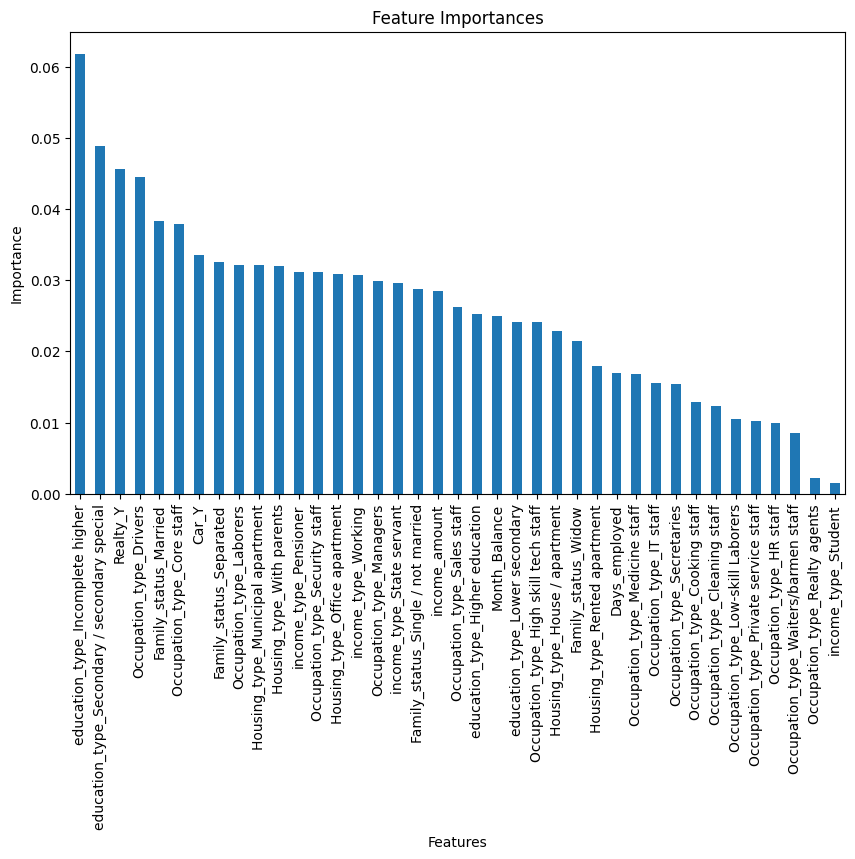

In [50]:
plt.figure(figsize=(10, 6))
feature.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Save the Models

In [54]:
joblib.dump(xgb_model, 'xgb_model.pkl')
loaded_model = joblib.load('xgb_model.pkl')

# Conclusion :

I think the model is good, from metrics, the values we got was:

1. **AdaBoost Classifier**
- **Accuracy: 0.50**

2. **Decision Tree Classifier**
- **Accuracy: 0.83**

3. **XGBoost Classifier**
- **Accuracy: 0.86**

therefore, i take XGBoost Classifier Model, because of the good values that got.